In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import numpy as np
from viz import plot_opinions_over_time, plot_campaign_budgets_with_order
from algos import compute_expected_value_for_budget_distribution, dynamic_programming_with_grid, forward_propagation_with_grid  
from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph

from algos import *

In [46]:
def create_adjacency_matrix_from_links(num_nodes, links):
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for link in links:
        from_node, to_node = link
        # adjacency_matrix[from_node, to_node] = 1
        adjacency_matrix[to_node, from_node] = 1

    return adjacency_matrix

def init_env(): 
    links = [
        (1, 3),
        (3, 2),
        
        (2, 3),
        (2, 0),
        (0, 2),
        
        (1, 2),
        (0, 1),
        
    ]

    num_nodes = 4
    connectivity_matrix = create_adjacency_matrix_from_links(num_nodes, links)
    # connectivity_matrix = normalize_adjacency_matrix(connectivity_matrix)

    initial_opinions = np.linspace(0.7, 0, num_nodes)
    # initial_opinions = np.linspace(0, 1, num_nodes)
    # initial_opinions = (np.mod(np.arange(0, 0.1 * num_nodes, 0.1), 0.9)) + 0.1

    env = NetworkGraph(
        connectivity_matrix=connectivity_matrix,
        initial_opinions=initial_opinions,
        max_u=0.2,
        budget=1000.0,
        desired_opinion=0.9,
        tau=0.5,
        max_steps=1_000_000,
    )

    env.reset()

    return env

[0.7        0.46666667 0.23333333 0.        ]


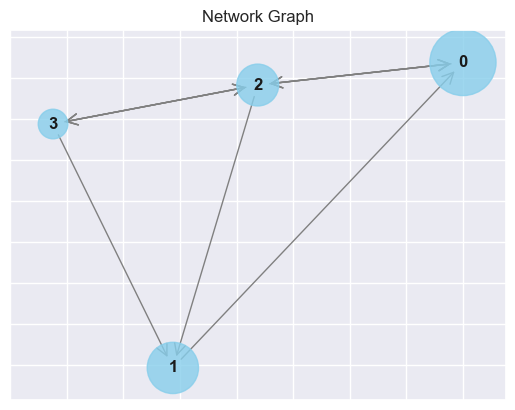

In [47]:
env = init_env()
print(env.opinions)
env.render(mode="matplotlib")

c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\rl_envs_forge\envs\network_graph\visualize.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_labels, y=sorted_centralities, palette="Blues_d")


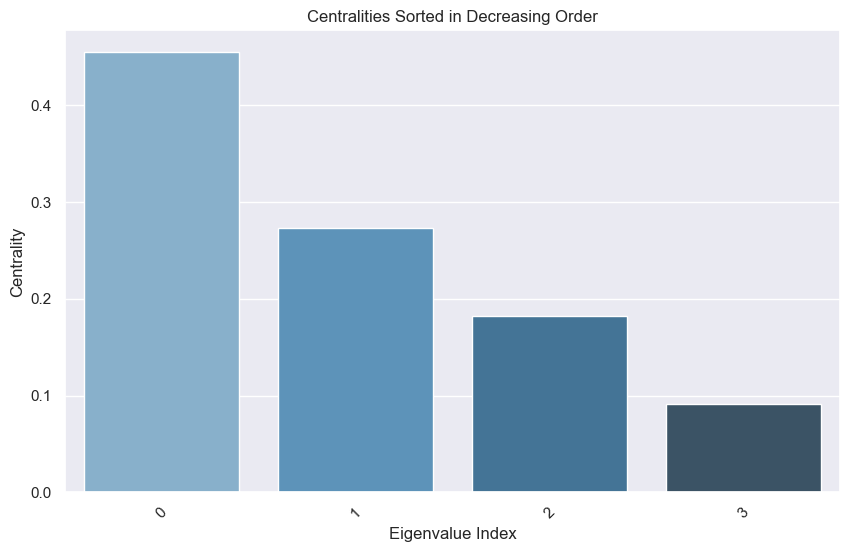

In [48]:
env.render(mode="centralities")

## Zero control 

Overall Error: 0.4204647904080085
Final Error: 0.4120701748735516


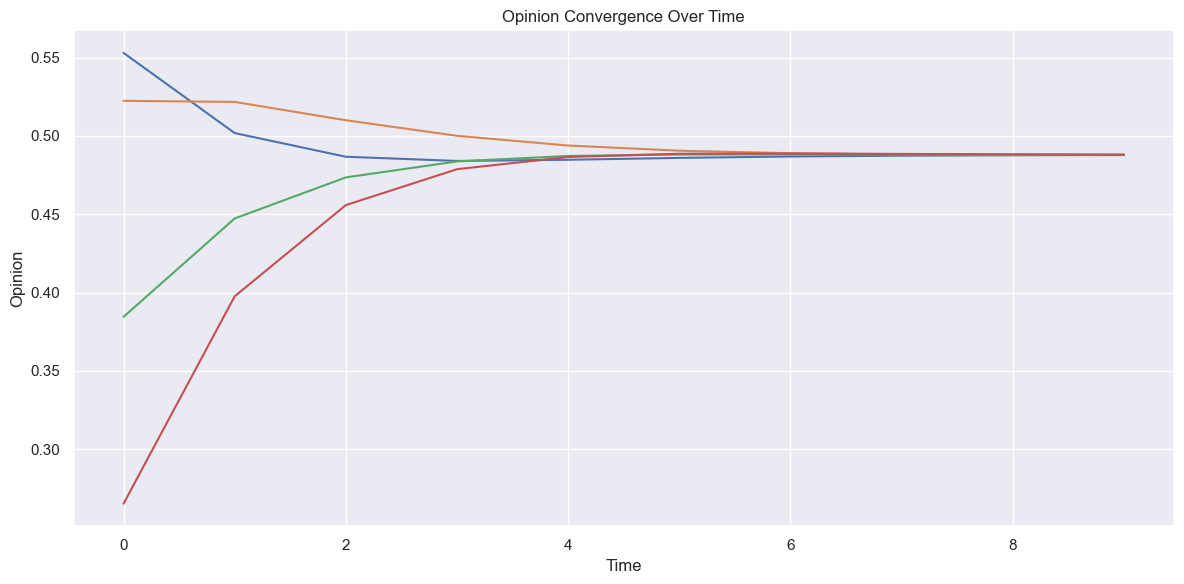

In [49]:
# Define the number of steps for which to apply the zero control input
env = init_env()

num_steps = 10

# Initialize an array to store opinions over time
opinions_over_time = np.zeros((num_steps, env.num_agents))

# Run the simulation with zero control input
for i in range(num_steps):
    no_action_u = np.zeros(env.num_agents)  # Zero control input
    opinions, reward, done, truncated, info = env.step(no_action_u)
    opinions_over_time[i] = opinions


overall_error_broadcast = compute_average_error(opinions_over_time, env.desired_opinion)
final_error_broadcast = compute_final_average_error(
    opinions_over_time, env.desired_opinion
)

print(f"Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time)

Overall Error: 0.33637183232640677
Final Error: 0.32965613989884124


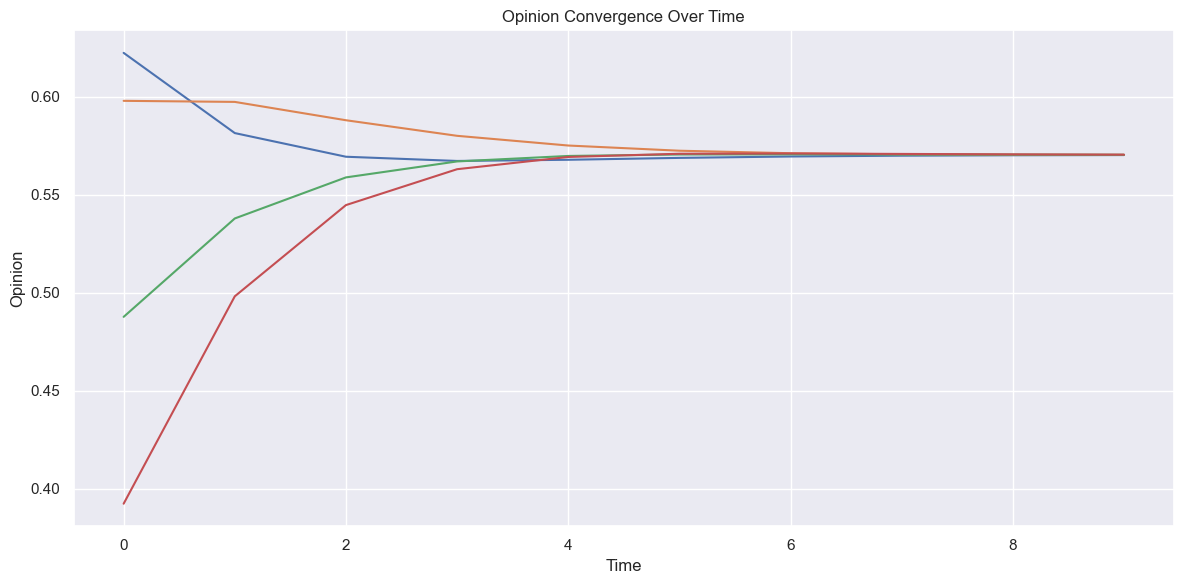

In [50]:
# Define the number of steps for which to apply the zero control input
env = init_env()

num_steps = 10

# Initialize an array to store opinions over time
opinions_over_time = np.zeros((num_steps, env.num_agents))

# Run the simulation with zero control input
for i in range(num_steps):
    if i == 0:
        action_u = np.ones(env.num_agents) * env.max_u 
        opinions, reward, done, truncated, info = env.step(action_u)
        opinions_over_time[i] = opinions
    else:
        no_action_u = np.zeros(env.num_agents)  # Zero control input
        opinions, reward, done, truncated, info = env.step(no_action_u)
        opinions_over_time[i] = opinions


overall_error_broadcast = compute_average_error(opinions_over_time, env.desired_opinion)
final_error_broadcast = compute_final_average_error(
    opinions_over_time, env.desired_opinion
)

print(f"Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time)

### Baseline 


Baseline Strategy - Overall Error: 0.09625985597262009
Final Error: 0.009280144686703906


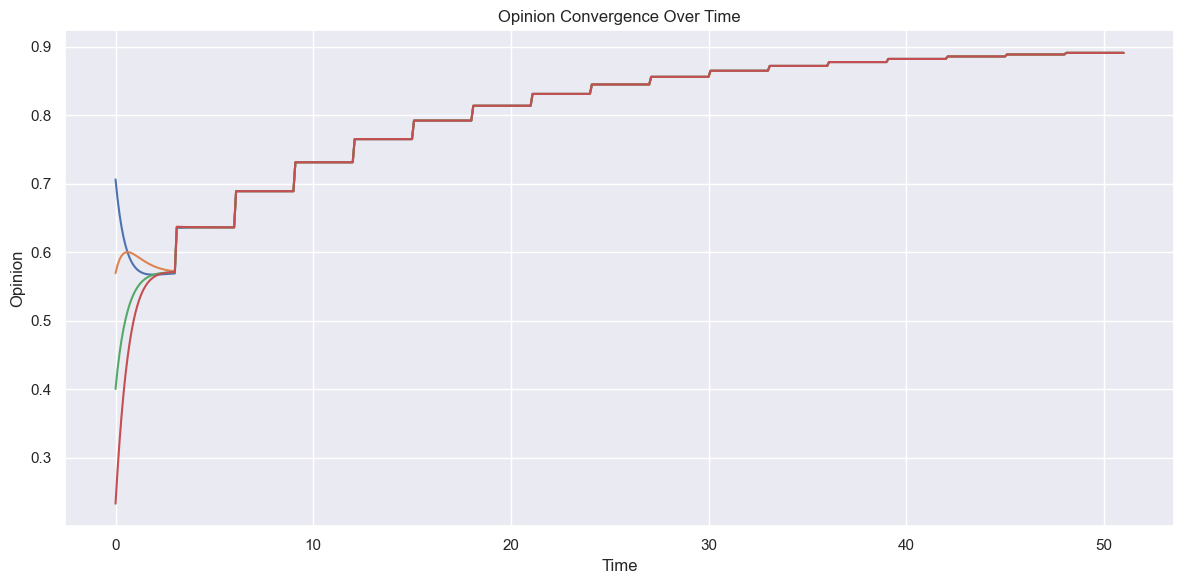

In [51]:
from algos import normalize_campaign_time, compute_average_error, compute_final_average_error
import numpy as np
from copy import deepcopy

def run_baseline_campaigns(env, step_duration, sampling_time, tolerance=0.01):
    """
    Run the simulation using a baseline strategy where full control is applied to all agents.

    Args:
        env: The environment with network properties.
        step_duration: Duration of each campaign step.
        sampling_time: Time between samples during a campaign.
        tolerance: Tolerance for the mean opinion to stop the campaigns.

    Returns:
        opinions_over_time: Array of opinions over the entire simulation.
        time_points: Corresponding time points for each opinion snapshot.
        nodes_controlled_simulation: List of nodes controlled in each campaign.
    """
    N = env.num_agents
    opinions_over_time = []
    time_points = []
    current_time = 0.0
    nodes_controlled_simulation = []
    X = env.opinions.copy()

    while True:
        controlled_nodes = np.arange(N)  # Control all nodes
        control_input = np.ones(N) * env.max_u  # Apply maximum control to all nodes

        # Apply control once and let the system evolve
        opinions_campaign, times_campaign = run_baseline_campaign_with_sampling(
            env, control_input, X, step_duration, sampling_time
        )

        # Adjust time points to include the cumulative time
        times_campaign += current_time

        # Append the opinions and time points from the current campaign
        if len(opinions_over_time) == 0:
            opinions_over_time = opinions_campaign
            time_points = times_campaign
        else:
            opinions_over_time = np.vstack((opinions_over_time, opinions_campaign[1:]))
            time_points = np.concatenate((time_points, times_campaign[1:]))

        # Update the current time and state
        current_time = time_points[-1]
        X = opinions_campaign[-1].copy()

        # Store controlled nodes for this campaign
        nodes_controlled_simulation.append(controlled_nodes)

        # Check if the mean opinion is within the tolerance
        mean_opinion_error = np.abs(np.mean(X) - env.desired_opinion)
        if mean_opinion_error <= tolerance:
            break

    return opinions_over_time, time_points, nodes_controlled_simulation


def run_baseline_campaign_with_sampling(env, control_input, X, step_duration, sampling_time):
    """
    Run a single campaign using full control with sampling.

    Args:
        env: The environment.
        control_input: The control input applied to all agents.
        X: Initial opinions.
        step_duration: Total duration of the campaign.
        sampling_time: Time between samples.

    Returns:
        opinions_over_time: Array of opinions over the campaign.
        time_points: Corresponding time points for each opinion snapshot.
    """
    N = env.num_agents
    num_samples = int(np.ceil(step_duration / sampling_time)) + 1
    opinions_over_time = np.zeros((num_samples, N))
    time_points = np.zeros(num_samples)

    # Apply control once at the beginning
    X = env.compute_dynamics(X, control_input, sampling_time)
    X = np.clip(X, 0, 1)
    opinions_over_time[0] = X
    time_points[0] = 0.0

    current_time = 0.0

    # Let the system evolve freely after applying control
    for idx in range(1, num_samples):
        dt = min(sampling_time, step_duration - current_time)
        current_time += dt

        # Propagate opinions without any control
        X = env.compute_dynamics(X, np.zeros(N), dt)
        X = np.clip(X, 0, 1)

        # Record the opinions and time
        opinions_over_time[idx] = X
        time_points[idx] = current_time

    return opinions_over_time, time_points


# Example Usage
env = init_env()
step_duration = 3  # Duration of each campaign
sampling_time = 0.1  # Sampling interval during each campaign
tolerance = 0.01  # Stopping criterion for mean opinion

# Run the baseline campaigns
opinions_over_time, time_points, nodes_controlled_simulation = run_baseline_campaigns(
    env, step_duration, sampling_time, tolerance
)

# Compute errors
overall_error = compute_average_error(opinions_over_time, env.desired_opinion)
final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)

print(f"\nBaseline Strategy - Overall Error: {overall_error}")
print(f"Final Error: {final_error}")

# Plot the opinions over time
plot_opinions_over_time(opinions_over_time, time_points)


In [52]:
# viz: per node, one axis mean of network, one axis opinion in node, represent taken action

### Infinite horizon

In [64]:
import numpy as np
from itertools import product
from scipy.linalg import expm
from copy import deepcopy

def create_state_grid(N, nx):
    grid_range = np.linspace(0, 1, nx)
    grids = [grid_range for _ in range(N)]
    return grids

def initialize_value_function(N, nx):
    grid_shape = tuple([nx] * N)
    return np.zeros(grid_shape)

def reward_function(x, u, d, beta):
    return -np.abs(d - x).sum() - beta * np.sum(u)

def value_iteration(env, nx=5, gamma=1.0, beta=0.0, step_duration=3.0, max_iterations=1000, tol=1e-6):
    N = env.num_agents
    ubar = env.max_u
    d = env.desired_opinion

    grids = create_state_grid(N, nx)
    grid_shape = tuple(len(grid) for grid in grids)

    V = initialize_value_function(N, nx)

    control_actions = list(product([0, ubar], repeat=N))

    for iteration in range(max_iterations):
        V_new = np.zeros_like(V)
        max_diff = 0

        for idx in np.ndindex(grid_shape):
            current_state = np.array([grids[i][idx[i]] for i in range(N)])
            best_value = -np.inf

            for control in control_actions:
                control_input = np.array(control)
                next_state = env.compute_dynamics(current_state, control_input, step_duration)

                next_idx = tuple(np.abs(grids[i] - next_state[i]).argmin() for i in range(N))

                future_value = V[next_idx]
                immediate_reward = reward_function(current_state, control_input, d, beta)

                total_value = immediate_reward + gamma * future_value
                if total_value > best_value:
                    best_value = total_value

            V_new[idx] = best_value
            max_diff = max(max_diff, abs(V_new[idx] - V[idx]))

        if max_diff < tol:
            print(f"Converged in {iteration + 1} iterations.")
            break

        V = V_new

    return V

def extract_policy(env, V, nx=5, gamma=1.0, beta=0.0, step_duration=3.0):
    N = env.num_agents
    ubar = env.max_u
    d = env.desired_opinion

    grids = create_state_grid(N, nx)
    grid_shape = tuple(len(grid) for grid in grids)

    control_actions = list(product([0, ubar], repeat=N))
    policy = {}

    for idx in np.ndindex(grid_shape):
        current_state = np.array([grids[i][idx[i]] for i in range(N)])
        best_value = -np.inf
        best_action = None

        for control in control_actions:
            control_input = np.array(control)
            next_state = env.compute_dynamics(current_state, control_input, step_duration)

            next_idx = tuple(np.abs(grids[i] - next_state[i]).argmin() for i in range(N))
            future_value = V[next_idx]

            immediate_reward = reward_function(current_state, control_input, d, beta)
            total_value = immediate_reward + gamma * future_value

            if total_value > best_value:
                best_value = total_value
                best_action = control_input

        policy[idx] = best_action if best_action is not None else np.zeros(N)

    return policy

beta = 0.1
gamma = 0.9 
step_duration = 3
nx = 4

# Run value iteration and extract policy
V = value_iteration(env, nx=nx, gamma=gamma, beta=beta, step_duration=step_duration, tol=1e-4)
policy = extract_policy(env, V, nx=nx, gamma=gamma, beta=beta, step_duration=step_duration)

Converged in 97 iterations.


In [65]:
policy

{(0, 0, 0, 0): array([0.2, 0.2, 0.2, 0.2]),
 (0, 0, 0, 1): array([0.2, 0.2, 0. , 0.2]),
 (0, 0, 0, 2): array([0.2, 0. , 0.2, 0. ]),
 (0, 0, 0, 3): array([0.2, 0. , 0. , 0. ]),
 (0, 0, 1, 0): array([0.2, 0.2, 0. , 0. ]),
 (0, 0, 1, 1): array([0.2, 0. , 0. , 0. ]),
 (0, 0, 1, 2): array([0. , 0.2, 0. , 0. ]),
 (0, 0, 1, 3): array([0. , 0. , 0.2, 0. ]),
 (0, 0, 2, 0): array([0. , 0.2, 0. , 0. ]),
 (0, 0, 2, 1): array([0. , 0.2, 0. , 0. ]),
 (0, 0, 2, 2): array([0, 0, 0, 0]),
 (0, 0, 2, 3): array([0, 0, 0, 0]),
 (0, 0, 3, 0): array([0, 0, 0, 0]),
 (0, 0, 3, 1): array([0, 0, 0, 0]),
 (0, 0, 3, 2): array([0, 0, 0, 0]),
 (0, 0, 3, 3): array([0, 0, 0, 0]),
 (0, 1, 0, 0): array([0.2, 0. , 0. , 0. ]),
 (0, 1, 0, 1): array([0.2, 0. , 0. , 0. ]),
 (0, 1, 0, 2): array([0. , 0. , 0.2, 0. ]),
 (0, 1, 0, 3): array([0, 0, 0, 0]),
 (0, 1, 1, 0): array([0. , 0. , 0. , 0.2]),
 (0, 1, 1, 1): array([0, 0, 0, 0]),
 (0, 1, 1, 2): array([0, 0, 0, 0]),
 (0, 1, 1, 3): array([0, 0, 0, 0]),
 (0, 1, 2, 0): array([0,

In [61]:
policy[(3, 3, 3, 3)]

array([0, 0, 0, 0])

In [ ]:
# Simulate the policy
def simulate_policy(env, policy, nx, step_duration, sampling_time, num_steps=100, tolerance=0.01):
    N = env.num_agents
    grids = create_state_grid(N, nx)
    state = env.opinions.copy()
    state_history = [state.copy()]
    control_history = []
    time_points = [0.0]
    current_time = 0.0

    for step in range(num_steps):
        # Map the current state to the closest grid point
        idx = tuple(np.abs(grids[i] - state[i]).argmin() for i in range(N))

        # Get the control action from the policy
        control = policy.get(idx, np.zeros(N))
        control_history.append(control.copy())

        # Simulate over the step_duration with sampling
        num_samples = int(np.ceil(step_duration / sampling_time))
        for _ in range(num_samples):
            dt = min(sampling_time, step_duration - (current_time - time_points[-1]))
            # Apply control only at the first sampling step within the step_duration
            if _ == 0:
                control_input = control
            else:
                control_input = np.zeros(N)
            # Update the state using the dynamics
            state = env.compute_dynamics(state, control_input, dt)
            state = np.clip(state, 0, 1)
            current_time += dt
            time_points.append(current_time)
            state_history.append(state.copy())

        print(f"Step {step}: State = {state}, Control = {control}")

        # Check if the mean opinion is within the tolerance
        mean_opinion_error = np.abs(np.mean(state) - env.desired_opinion)
        if mean_opinion_error <= tolerance:
            print("Desired opinion reached.")
            break

    return np.array(state_history), np.array(time_points), control_history


sampling_time = 0.1
state_history, time_points, control_history = simulate_policy(env, policy, nx=nx, step_duration=3.0, sampling_time=sampling_time)


overall_error = compute_average_error(state_history, env.desired_opinion)
final_error = compute_final_average_error(state_history, env.desired_opinion)

print(f"\nOptimal Policy Strategy - Overall Error: {overall_error}")
print(f"Final Error: {final_error}")

Step 0: State = [0.48599651 0.49056972 0.48816784 0.48863927], Control = [0 0 0 0]
Step 1: State = [0.48787161 0.48786854 0.48789433 0.4879143 ], Control = [0 0 0 0]
Step 2: State = [0.48787896 0.48787863 0.4878787  0.48787858], Control = [0 0 0 0]
Step 3: State = [0.48787879 0.48787879 0.48787879 0.48787879], Control = [0 0 0 0]
Step 4: State = [0.48787879 0.48787879 0.48787879 0.48787879], Control = [0 0 0 0]
Step 5: State = [0.48787879 0.48787879 0.48787879 0.48787879], Control = [0 0 0 0]
Step 6: State = [0.48787879 0.48787879 0.48787879 0.48787879], Control = [0 0 0 0]
Step 7: State = [0.48787879 0.48787879 0.48787879 0.48787879], Control = [0 0 0 0]
Step 8: State = [0.48787879 0.48787879 0.48787879 0.48787879], Control = [0 0 0 0]
Step 9: State = [0.48787879 0.48787879 0.48787879 0.48787879], Control = [0 0 0 0]
Step 10: State = [0.48787879 0.48787879 0.48787879 0.48787879], Control = [0 0 0 0]
Step 11: State = [0.48787879 0.48787879 0.48787879 0.48787879], Control = [0 0 0 0]
St

In [56]:
raise NotImplementedError

NotImplementedError: 

Dynamic Programming Strategy - Overall Error: 0.42578485812860584
Final Error: 0.3889476629653289
[array([1, 2], dtype=int64), array([0, 1], dtype=int64)]


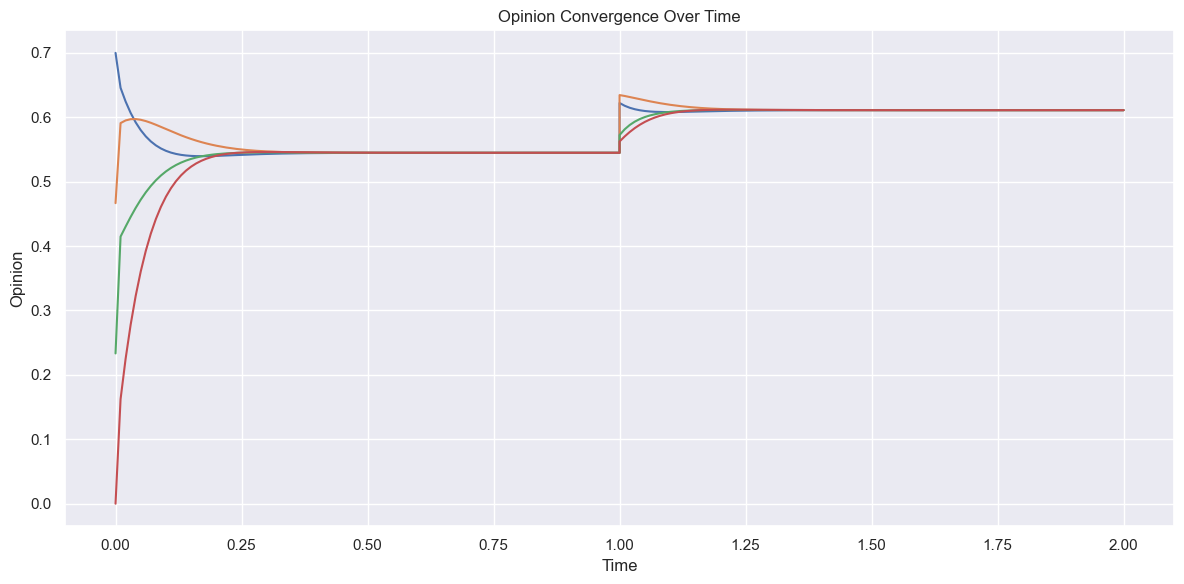

In [ ]:
from algos import normalize_campaign_time, run_dynamic_programming_campaigns

env = init_env()

step_duration = 10
step_duration = 0.1
final_campaign_step_duration = 10  # Longer duration for the final campaign
final_campaign_sampling_time = step_duration

# Run the campaigns using the optimal budget allocations
opinions_over_time_dp, time_points_dp, nodes_controlled_simulation = (
    run_dynamic_programming_campaigns(
        env,
        BETA,
        step_duration,
        step_duration,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )
)

# Compute errors
overall_error_dp = compute_average_error(opinions_over_time_dp, env.desired_opinion)
final_error_dp = compute_final_average_error(opinions_over_time_dp, env.desired_opinion)

print(f"Dynamic Programming Strategy - Overall Error: {overall_error_dp}")
print(f"Final Error: {final_error_dp}")

# Compute campaign durations
campaign_durations = [step_duration] * (M - 1) + [final_campaign_step_duration]
normalized_time_points_dp = normalize_campaign_time(
    time_points_dp, campaign_durations, step_duration, final_campaign_step_duration
)

print(nodes_controlled_simulation)

# plot_opinions_over_time(opinions_over_time_dp, time_points_dp)
plot_opinions_over_time(opinions_over_time_dp, normalized_time_points_dp)

### Fine DP

Dynamic Programming Strategy - Overall Error: 0.42578485812860584
Final Error: 0.3889476629653289
[array([1, 2], dtype=int64), array([0, 1], dtype=int64)]


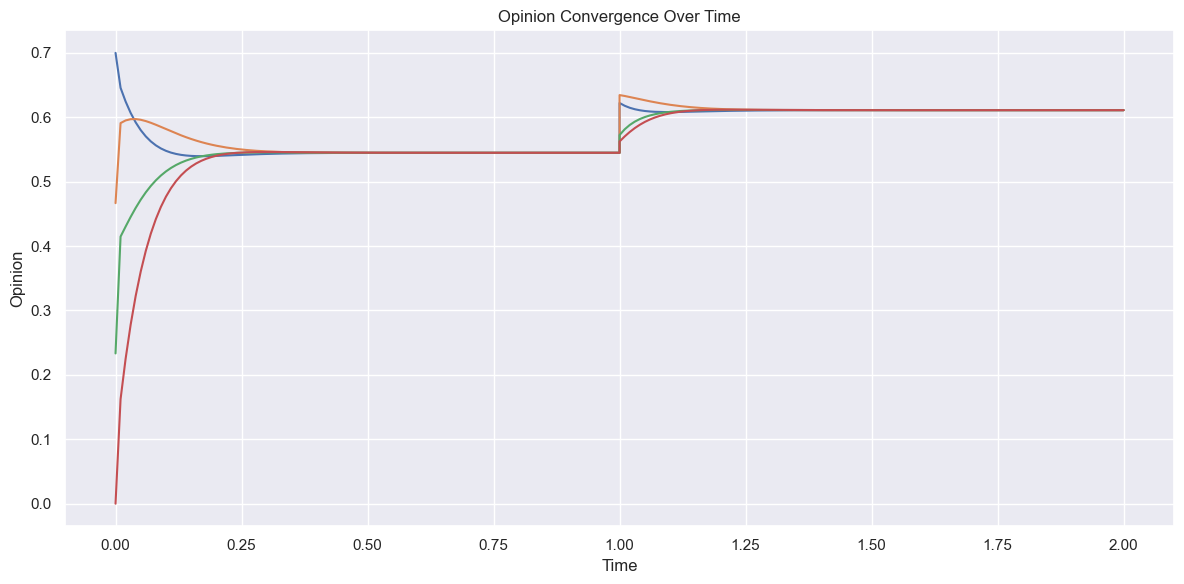

In [ ]:
from algos import normalize_campaign_time, run_dynamic_programming_campaigns

env = init_env()

step_duration = 10
step_duration = 0.1
final_campaign_step_duration = 10  # Longer duration for the final campaign
final_campaign_sampling_time = step_duration

# Run the campaigns using the optimal budget allocations
opinions_over_time_dp, time_points_dp, nodes_controlled_simulation = (
    run_dynamic_programming_campaigns(
        env,
        BETA_hd,
        step_duration,
        step_duration,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )
)

# Compute errors
overall_error_dp = compute_average_error(opinions_over_time_dp, env.desired_opinion)
final_error_dp = compute_final_average_error(opinions_over_time_dp, env.desired_opinion)

print(f"Dynamic Programming Strategy - Overall Error: {overall_error_dp}")
print(f"Final Error: {final_error_dp}")

# Compute campaign durations
campaign_durations = [step_duration] * (M - 1) + [final_campaign_step_duration]
normalized_time_points_dp = normalize_campaign_time(
    time_points_dp, campaign_durations, step_duration, final_campaign_step_duration
)

print(nodes_controlled_simulation)

# plot_opinions_over_time(opinions_over_time_dp, time_points_dp)
plot_opinions_over_time(opinions_over_time_dp, normalized_time_points_dp)

In [ ]:
### Brute force search

from itertools import product
from algos import run_dynamic_programming_campaigns, compute_average_error, compute_final_average_error
from viz import plot_opinions_over_time
from tqdm import tqdm

# Define parameters
total_budget = 4
num_campaigns = 2  # Number of campaigns
step_duration = 10
final_campaign_step_duration = 10  # Longer duration for the final campaign
step_duration = 0.1
final_campaign_sampling_time = 0.1

# Initialize environment
env = init_env()

# Function to generate all valid budget allocations
def generate_valid_budget_allocations(total_budget, num_campaigns):
    """Generate all budget combinations where the sum of budgets is <= total_budget."""
    allocations = []
    for allocation in product(range(total_budget + 1), repeat=num_campaigns):
        if sum(allocation) <= total_budget:
            allocations.append(allocation)
    return allocations

# Get all valid budget allocations
valid_budget_allocations = generate_valid_budget_allocations(total_budget, num_campaigns)

# Store all results: budget combination and corresponding final error
results = []

# Brute-force search over all budget allocations
for budget_allocation in tqdm(valid_budget_allocations, desc="Running Campaigns"):
    # Reset environment for each test
    env = init_env()

    # Run the campaigns using the current budget allocation
    opinions_over_time, time_points, nodes_controlled_simulation = run_dynamic_programming_campaigns(
        env,
        budget_allocation,
        step_duration,
        step_duration,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )

    # Compute final error
    final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)

    # Store the result as a tuple of (budget_allocation, final_error)
    results.append((budget_allocation, final_error))

# Sort results by final error (ascending)
results_sorted_by_error = sorted(results, key=lambda x: x[1])

# Function to display top N budget combinations
def show_top_n_budget_combinations(results_sorted, top_n=5):
    print(f"Top {top_n} Budget Combinations by Final Error:")
    for i in range(min(top_n, len(results_sorted))):
        budget_allocation, final_error = results_sorted[i]
        print(f"Rank {i+1}: Budget: {budget_allocation}, Final Error: {final_error}")

# Display the top N budget combinations
show_top_n_budget_combinations(results_sorted_by_error, top_n=5)

NameError: name 'init_env' is not defined

In [ ]:
# results_sorted_by_error